# New Market Analysis

An analysis of an on-demand delivery platform’s order and delivery data. The purpose of the analysis is to report on the company’s performance in it’s newest market, New York City.

## Data

### Metadata

job_ID: a unique identifier of a delivery

customer_id: a unique identifier for the customer

deliveryman_id: a unique identifier for the deliveryman who completed the delivery

vehicle_type: The method of transport the deliveryman used to complete the delivery

pickup_place: The name of the pickup location

place_category: a categorization of the Pickup location

item_name: the name of the item requested

item_quantity: how many of that item was requested

item_category_name: categorization provided by merchant, think “appetizers”, “soups” etc

how_long_it_took_to_order: how long it took to place the order [interval]

pickup_lat: the coordinates of the pickup location

pickup_lon: the coordinates of the pickup location

dropoff_lat: the coordinations of the dropoff location

dropoff_lon: the coordinations of the dropoff location

when_the_delivery_started: localized timestamp representing when the delivery began

when_the_deliveryman_arrived_at_pickup: localized timestamp representing when the deliveryman arrived at the pickup location

when_the_deliveryman_left_pickup: localized timestamp representing when the deliveryman left the pickup location

when_the_deliveryman_arrived_at_dropoff: localized timestamp representing when the deliveryman reached the customer

In [1]:
# dependencies 
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math
import pygsheets 
import sweetviz as sv

In [2]:
#authorization
keys = 'keys/gkeys.json'
gc = pygsheets.authorize(service_file=keys)

In [3]:
# import dataset 
df = pd.read_csv('data.csv', encoding= 'ISO-8859-1')
df.head()

,delivery_id,customer_id,deliveryman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_deliveryman_arrived_at_pickup,when_the_deliveryman_left_pickup,when_the_deliveryman_arrived_at_dropoff
0,1457973,327168,162381,van,Melt Shop,American,Lemonade,1.0,Beverages,0:19:59,40.744607,-73.990742,40.752073,-73.985370,0:52:00,NaN,NaN,0:52:06
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,0:25:09,40.723080,-73.994615,40.719722,-73.991858,0:58:59,0:26:02,0:48:23,0:59:23
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,0:06:45,40.728478,-73.998392,40.728606,-73.995143,0:39:53,0:37:19,0:59:10,0:04:41
3,1485494,271149,157175,bicycle,Juice Press,Juice Bar,OMG! My Favorite Juice!,1.0,Cold Pressed Juices,NaN,40.738868,-74.002747,40.751257,-74.005634,0:54:12,0:04:18,0:16:38,0:32:38
4,1327707,122609,118095,bicycle,Blue Ribbon Sushi,Japanese,Spicy Tuna & Tempura Flakes,2.0,Maki (Special Rolls),0:03:45,40.726110,-74.002492,40.709323,-74.015867,0:07:19,0:14:43,0:25:19,0:48:27


## Preprocess

In [4]:
df.dtypes

delivery_id                                  int64
customer_id                                  int64
deliveryman_id                               int64
vehicle_type                                object
pickup_place                                object
place_category                              object
item_name                                   object
item_quantity                              float64
item_category_name                          object
how_long_it_took_to_order                   object
pickup_lat                                 float64
pickup_lon                                 float64
dropoff_lat                                float64
dropoff_lon                                float64
when_the_delivery_started                   object
when_the_deliveryman_arrived_at_pickup      object
when_the_deliveryman_left_pickup            object
when_the_deliveryman_arrived_at_dropoff     object
dtype: object

In [5]:
pd.options.mode.chained_assignment = None  # default='warn'

# Select only delivery_id and how_long_it_took_to_order
ordertime = df.iloc[:,[0,9]]

# Add columns and Split how_long_it_took_to_order
ordertime[['hours', 'minutes', 'seconds']] = ordertime.how_long_it_took_to_order.str.split(":",expand=True) 

# Convert string to float                          
ordertime['minutes_f'] = pd.to_numeric(ordertime['minutes'], downcast='float')
ordertime['seconds_f'] = pd.to_numeric(ordertime['seconds'], downcast='float')

# add column to convert seconds to minutes
ordertime['seconds_conversion'] = ordertime['seconds_f'] / 60

# add column and add seconds_conversion to minutes column
ordertime['order_duration_in_min'] = ordertime['minutes_f'] + ordertime['seconds_conversion']

# drop columns not needed
ordertime = ordertime.drop(['hours', 'minutes', 'seconds'], axis=1)

# group by delivery_id 
ordertime = ordertime.groupby('delivery_id').max()

ordertime.head()

,how_long_it_took_to_order,minutes_f,seconds_f,seconds_conversion,order_duration_in_min
delivery_id,,,,,
1271706,NaN,NaN,NaN,NaN,NaN
1271751,NaN,NaN,NaN,NaN,NaN
1271867,NaN,NaN,NaN,NaN,NaN
1272279,0:09:09,9.0,9.0,0.15,9.15
1272303,NaN,NaN,NaN,NaN,NaN


In [6]:
# cast columns to datetime
df['when_the_delivery_started'] = pd.to_datetime(df['when_the_delivery_started'], format="%H:%M:%S") 
df['when_the_deliveryman_arrived_at_pickup'] = pd.to_datetime(df['when_the_deliveryman_arrived_at_pickup'], format="%H:%M:%S")
df['when_the_deliveryman_left_pickup'] = pd.to_datetime(df['when_the_deliveryman_left_pickup'], format="%H:%M:%S")
df['when_the_deliveryman_arrived_at_dropoff'] = pd.to_datetime(df['when_the_deliveryman_arrived_at_dropoff'], format="%H:%M:%S")

In [7]:
# drop unnecessary columns
ordertime = ordertime.drop(['how_long_it_took_to_order', 'minutes_f', 'seconds_f', 'seconds_conversion'], axis=1)

# merge dataframes
df = pd.merge(df, ordertime, on="delivery_id")

df.head()

,delivery_id,customer_id,deliveryman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,when_the_delivery_started,when_the_deliveryman_arrived_at_pickup,when_the_deliveryman_left_pickup,when_the_deliveryman_arrived_at_dropoff,order_duration_in_min
0,1457973,327168,162381,van,Melt Shop,American,Lemonade,1.0,Beverages,0:19:59,40.744607,-73.990742,40.752073,-73.985370,1900-01-01 00:52:00,NaT,NaT,1900-01-01 00:52:06,19.983334
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,0:25:09,40.723080,-73.994615,40.719722,-73.991858,1900-01-01 00:58:59,1900-01-01 00:26:02,1900-01-01 00:48:23,1900-01-01 00:59:23,25.150000
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,0:06:45,40.728478,-73.998392,40.728606,-73.995143,1900-01-01 00:39:53,1900-01-01 00:37:19,1900-01-01 00:59:10,1900-01-01 00:04:41,6.750000
3,1485494,271149,157175,bicycle,Juice Press,Juice Bar,OMG! My Favorite Juice!,1.0,Cold Pressed Juices,NaN,40.738868,-74.002747,40.751257,-74.005634,1900-01-01 00:54:12,1900-01-01 00:04:18,1900-01-01 00:16:38,1900-01-01 00:32:38,NaN
4,1327707,122609,118095,bicycle,Blue Ribbon Sushi,Japanese,Spicy Tuna & Tempura Flakes,2.0,Maki (Special Rolls),0:03:45,40.726110,-74.002492,40.709323,-74.015867,1900-01-01 00:07:19,1900-01-01 00:14:43,1900-01-01 00:25:19,1900-01-01 00:48:27,3.750000


In [8]:
# calculate time deltas if time of latter location is later than time of former location in order to result in a delta that is not negative. If the delta is negative then this would indicate a data quality issue since the timestamp between former and latter locations are not in order.

df['delivery_duration'] = np.where((df['when_the_delivery_started'] < df['when_the_deliveryman_arrived_at_dropoff']) == True , (df['when_the_deliveryman_arrived_at_dropoff'] - df['when_the_delivery_started']).dt.total_seconds()/60, math.nan)

df['time_length_of_arrival'] = np.where((df['when_the_delivery_started'] < df['when_the_deliveryman_arrived_at_pickup']) == True, (df['when_the_deliveryman_arrived_at_pickup'] - df['when_the_delivery_started']).dt.total_seconds()/60, math.nan)

df['time_spent_at_pickup'] = np.where((df['when_the_deliveryman_arrived_at_pickup'] < df['when_the_deliveryman_left_pickup']) == True, (df['when_the_deliveryman_left_pickup'] - df['when_the_deliveryman_arrived_at_pickup']).dt.total_seconds()/60, math.nan)

df['time_length_of_dropoff'] = np.where((df['when_the_deliveryman_left_pickup'] < df['when_the_deliveryman_arrived_at_dropoff']) == True, (df['when_the_deliveryman_arrived_at_dropoff'] - df['when_the_deliveryman_left_pickup']).dt.total_seconds()/60, math.nan)

df.head()


,delivery_id,customer_id,deliveryman_id,vehicle_type,pickup_place,place_category,item_name,item_quantity,item_category_name,how_long_it_took_to_order,...,dropoff_lon,when_the_delivery_started,when_the_deliveryman_arrived_at_pickup,when_the_deliveryman_left_pickup,when_the_deliveryman_arrived_at_dropoff,order_duration_in_min,delivery_duration,time_length_of_arrival,time_spent_at_pickup,time_length_of_dropoff
0,1457973,327168,162381,van,Melt Shop,American,Lemonade,1.0,Beverages,0:19:59,...,-73.985370,1900-01-01 00:52:00,NaT,NaT,1900-01-01 00:52:06,19.983334,0.100000,NaN,NaN,NaN
1,1377056,64452,104533,bicycle,Prince Street Pizza,Pizza,Neapolitan Rice Balls,3.0,Munchables,0:25:09,...,-73.991858,1900-01-01 00:58:59,1900-01-01 00:26:02,1900-01-01 00:48:23,1900-01-01 00:59:23,25.150000,0.400000,NaN,22.350000,11.000000
2,1476547,83095,132725,bicycle,Bareburger,Burger,Bare Sodas,1.0,Drinks,0:06:45,...,-73.995143,1900-01-01 00:39:53,1900-01-01 00:37:19,1900-01-01 00:59:10,1900-01-01 00:04:41,6.750000,NaN,NaN,21.850000,NaN
3,1485494,271149,157175,bicycle,Juice Press,Juice Bar,OMG! My Favorite Juice!,1.0,Cold Pressed Juices,NaN,...,-74.005634,1900-01-01 00:54:12,1900-01-01 00:04:18,1900-01-01 00:16:38,1900-01-01 00:32:38,NaN,NaN,NaN,12.333333,16.000000
4,1327707,122609,118095,bicycle,Blue Ribbon Sushi,Japanese,Spicy Tuna & Tempura Flakes,2.0,Maki (Special Rolls),0:03:45,...,-74.015867,1900-01-01 00:07:19,1900-01-01 00:14:43,1900-01-01 00:25:19,1900-01-01 00:48:27,3.750000,41.133333,7.4,10.600000,23.133333


## Exploratory Data Analysis

In [9]:
# attributesa
df.size

137609

In [10]:
df.shape

(5983, 23)

In [11]:
df.dtypes

delivery_id                                         int64
customer_id                                         int64
deliveryman_id                                      int64
vehicle_type                                       object
pickup_place                                       object
place_category                                     object
item_name                                          object
item_quantity                                     float64
item_category_name                                 object
how_long_it_took_to_order                          object
pickup_lat                                        float64
pickup_lon                                        float64
dropoff_lat                                       float64
dropoff_lon                                       float64
when_the_delivery_started                  datetime64[ns]
when_the_deliveryman_arrived_at_pickup     datetime64[ns]
when_the_deliveryman_left_pickup           datetime64[ns]
when_the_deliv

In [12]:
# missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis = 1, keys=["total", "percent"])
missing_data

,total,percent
delivery_duration,3441,0.575130
how_long_it_took_to_order,2945,0.492228
order_duration_in_min,2945,0.492228
time_spent_at_pickup,2210,0.369380
time_length_of_arrival,2126,0.355340
time_length_of_dropoff,1816,0.303527
item_name,1230,0.205582
item_quantity,1230,0.205582
item_category_name,1230,0.205582
place_category,883,0.147585


In [13]:
#analyzing the dataset
report = sv.analyze(df)

#display the report
report.show_html('report.html')

                                             |     | [  0%]   00:00 -> (? left)

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



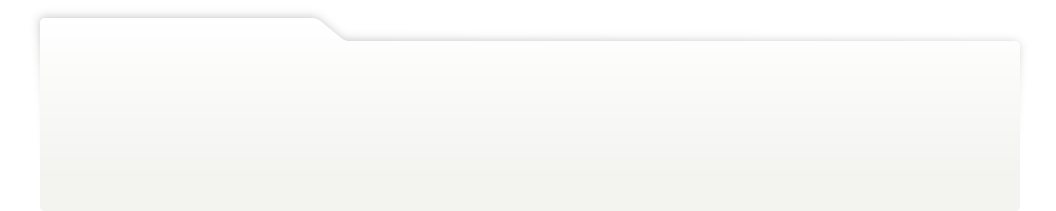
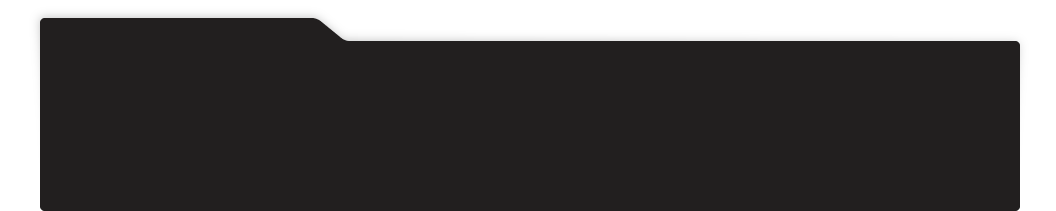
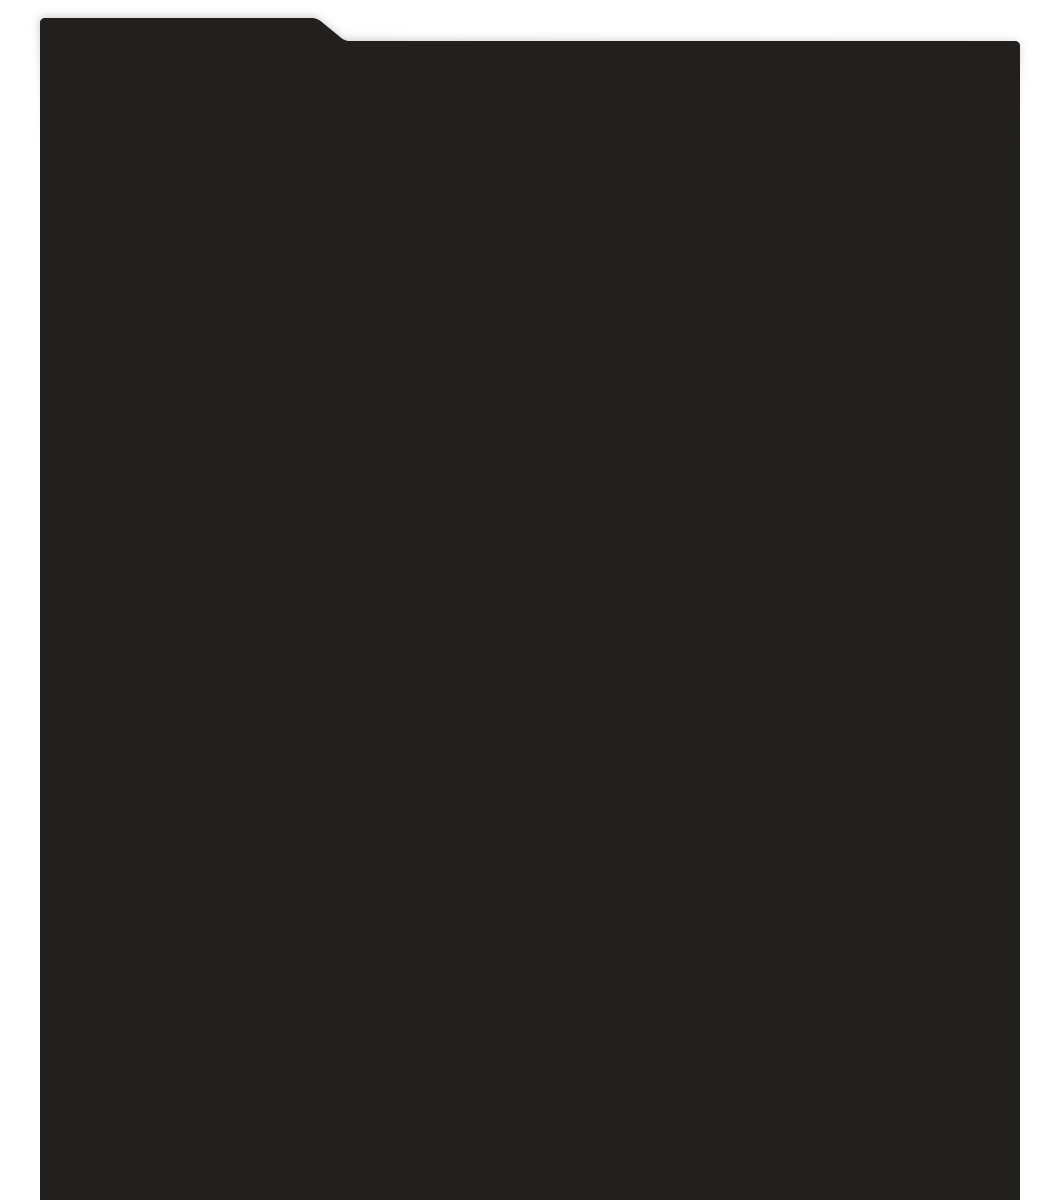
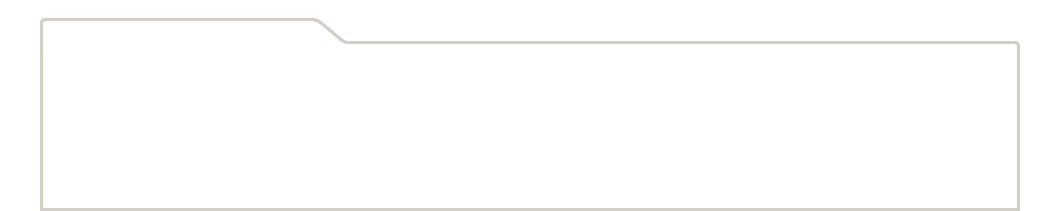
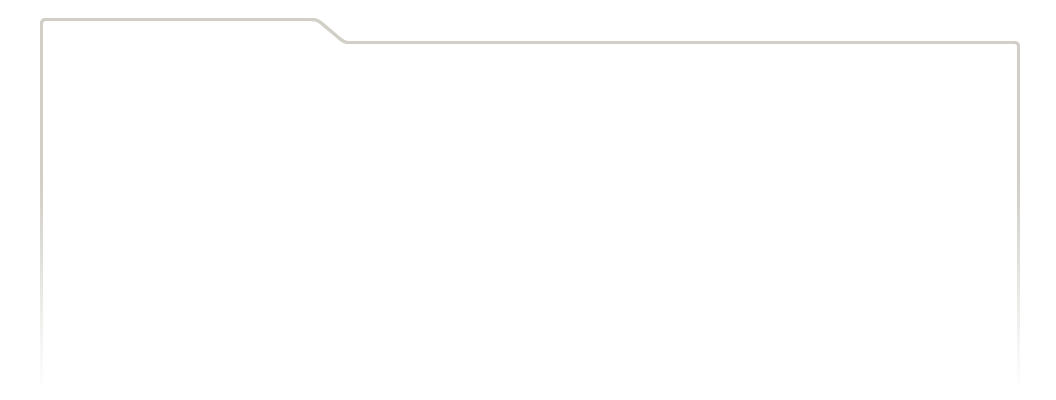
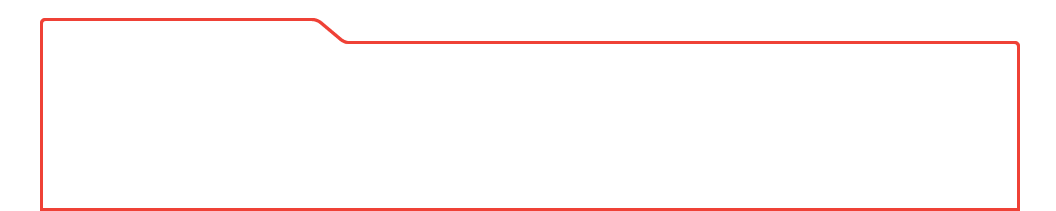
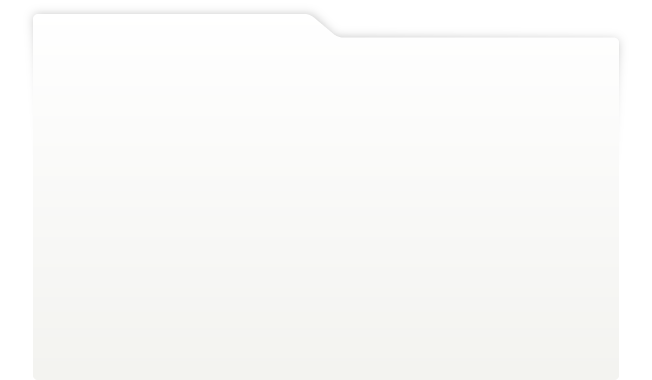
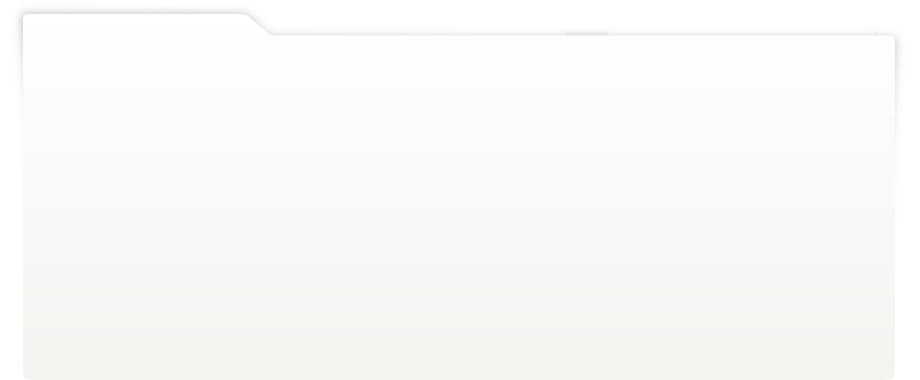
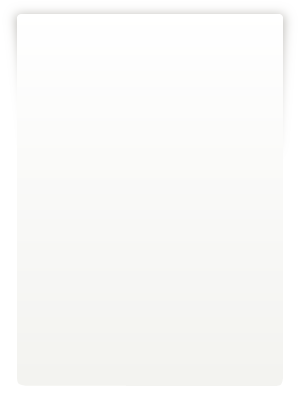
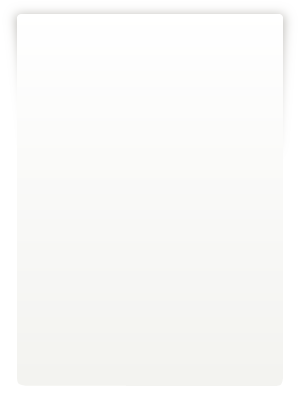
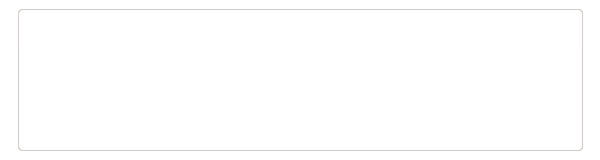
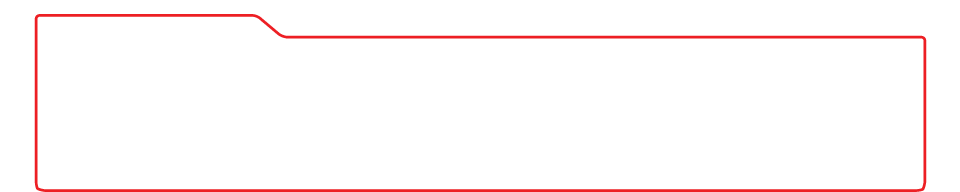
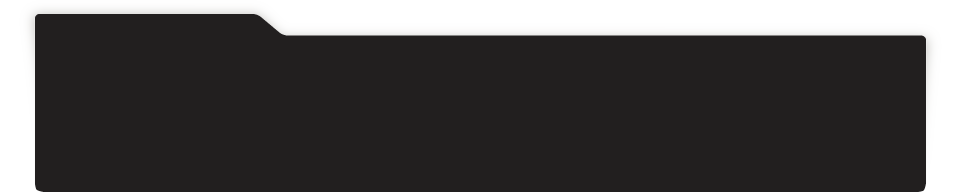
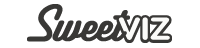
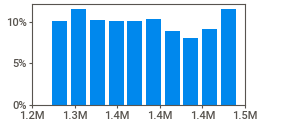
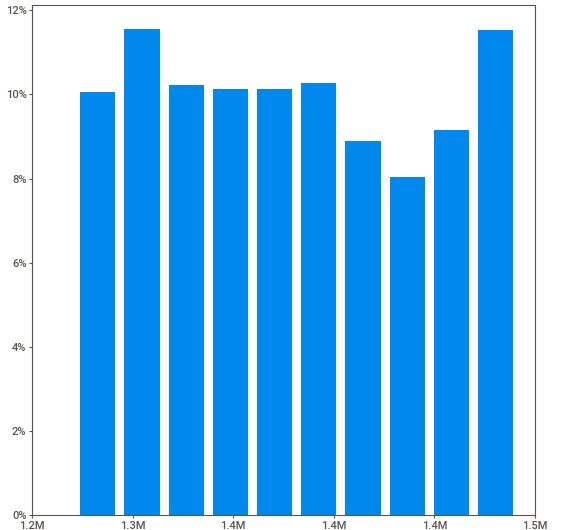
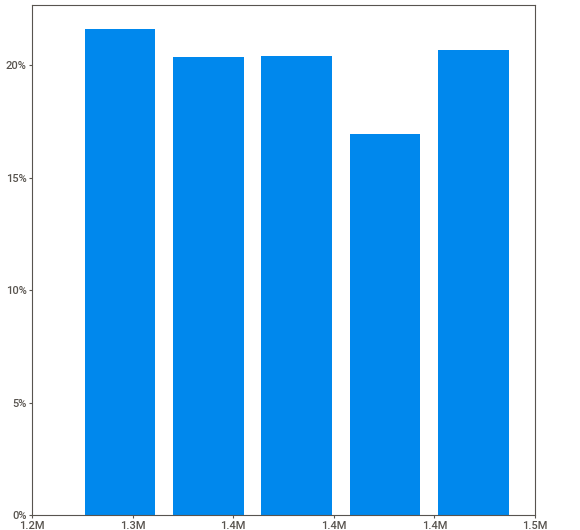
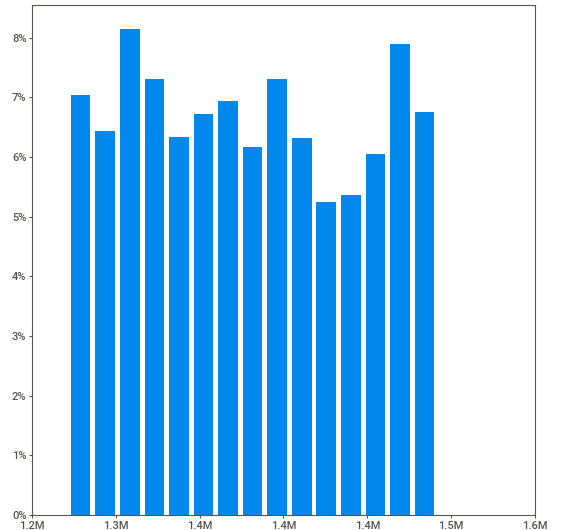
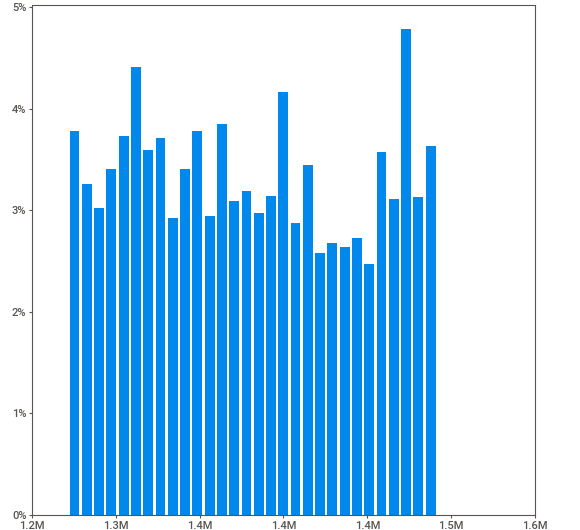
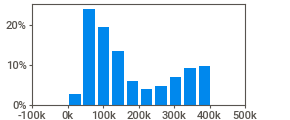
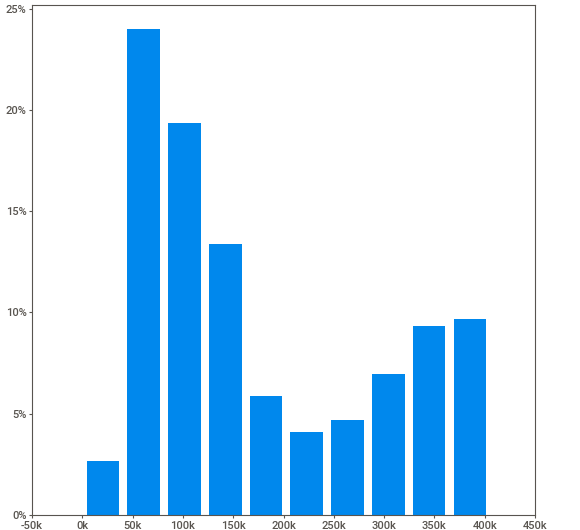
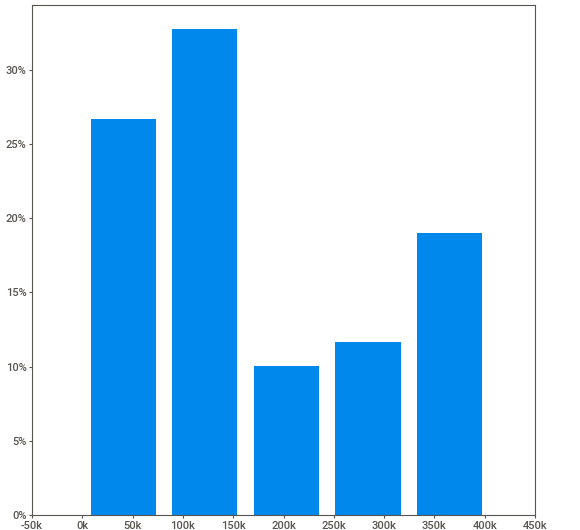
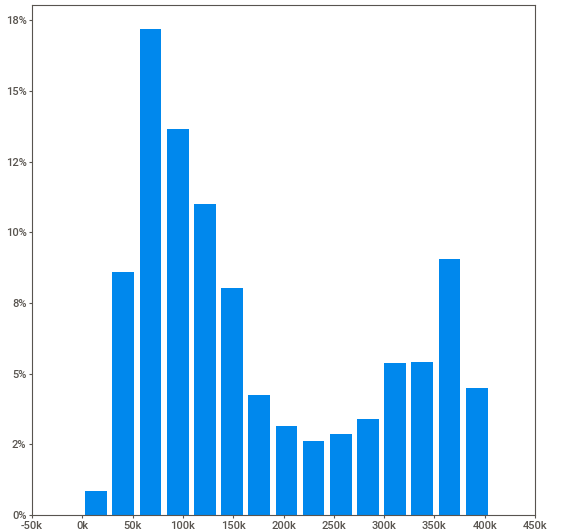
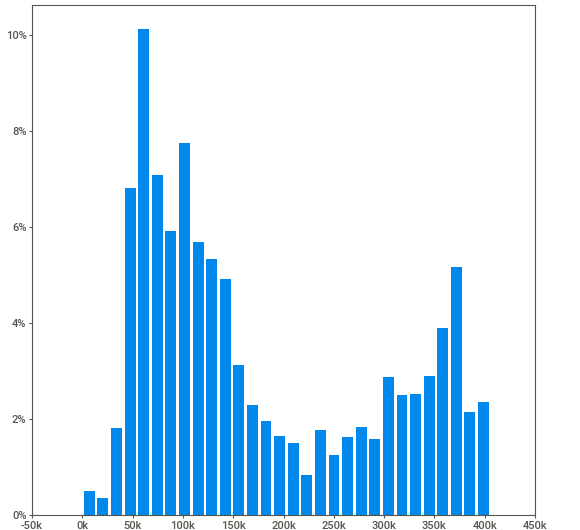
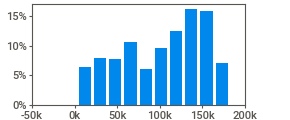
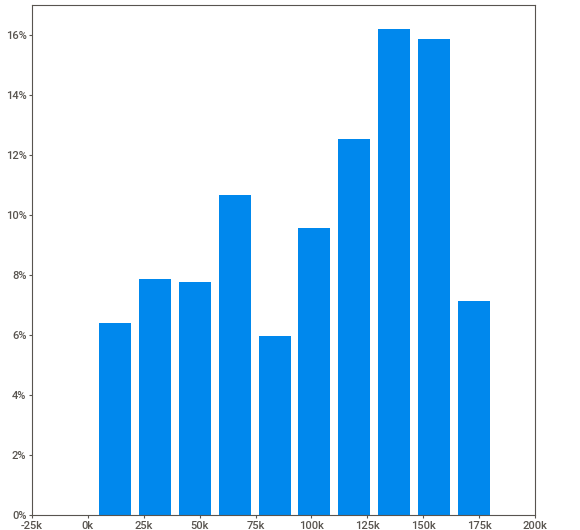
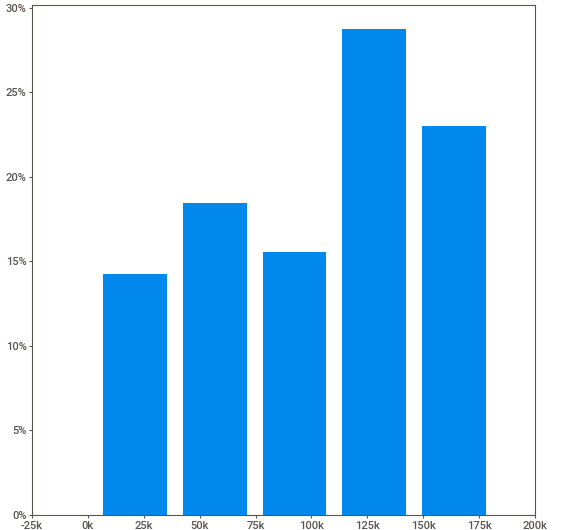
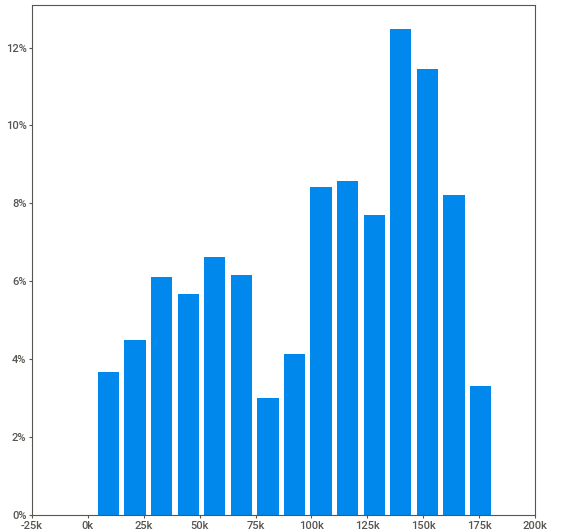
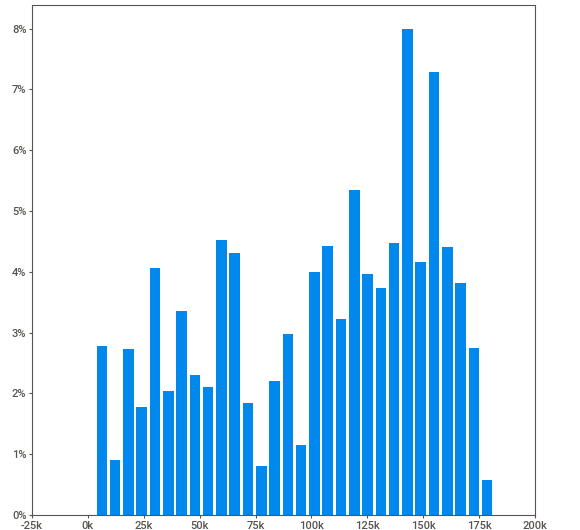
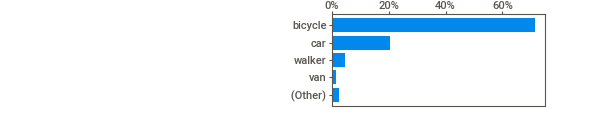
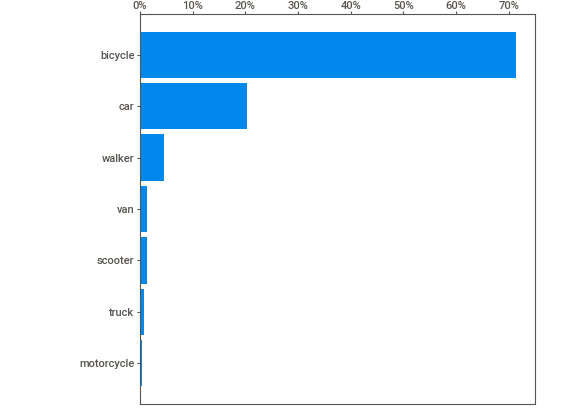
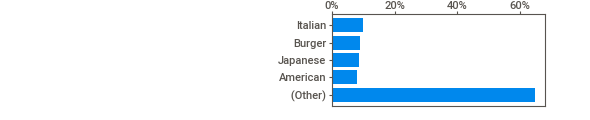
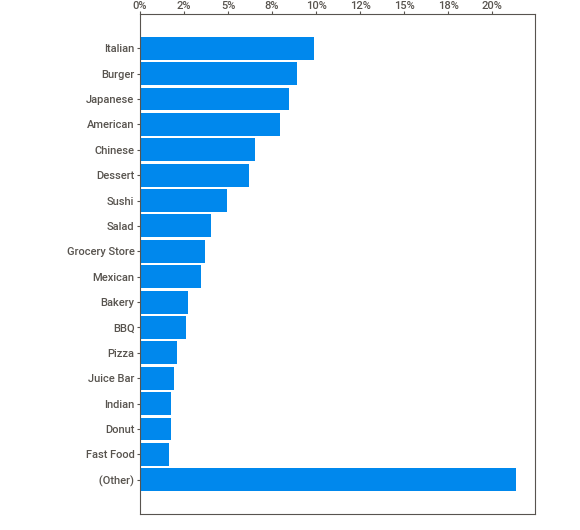
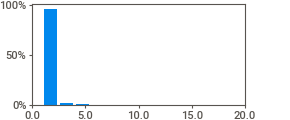
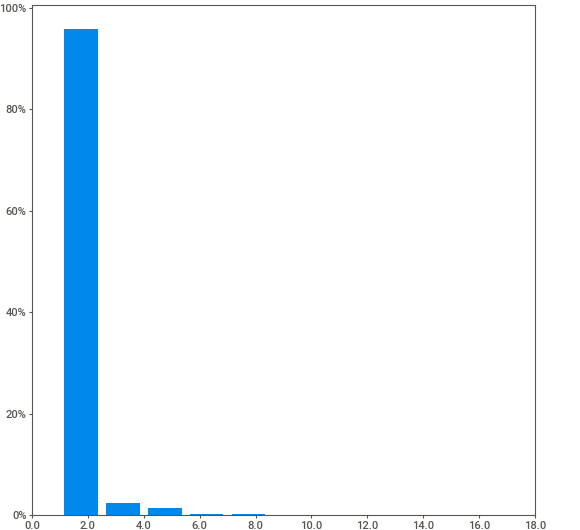
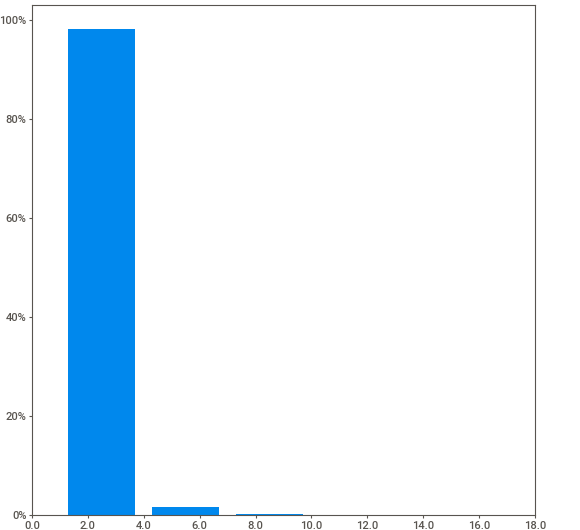
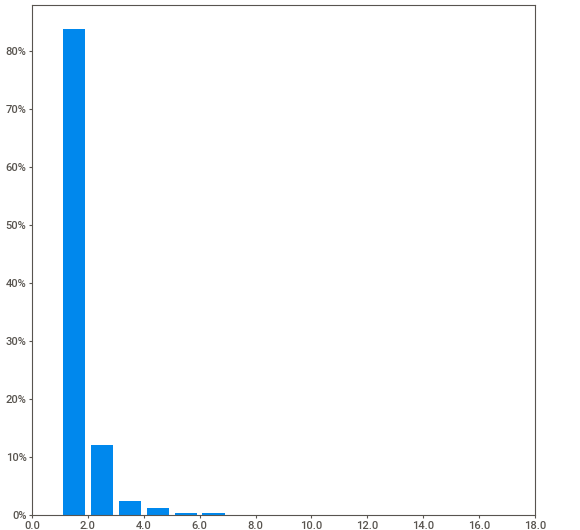
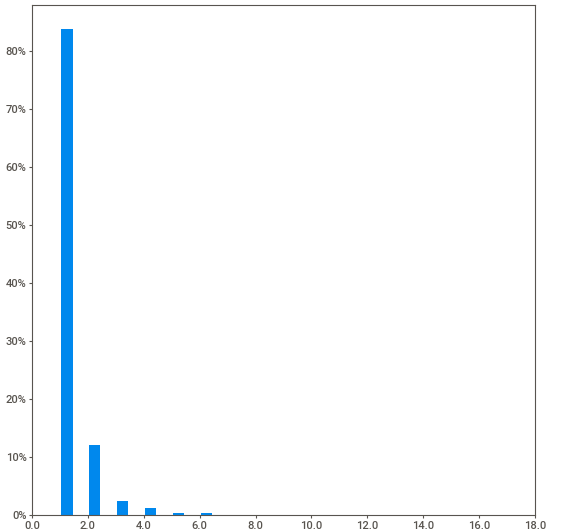
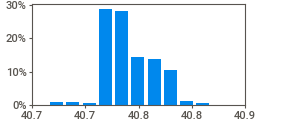
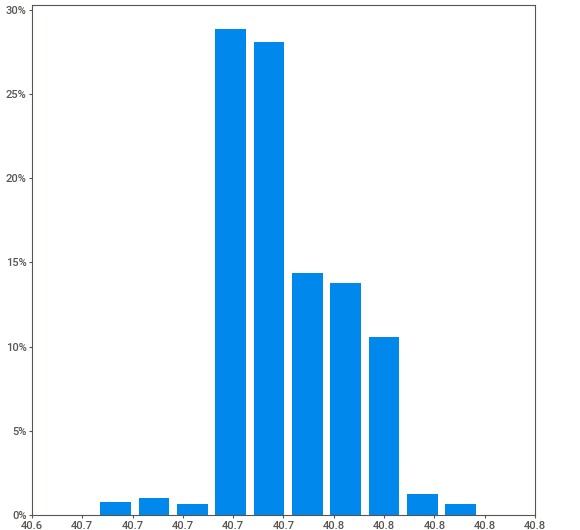
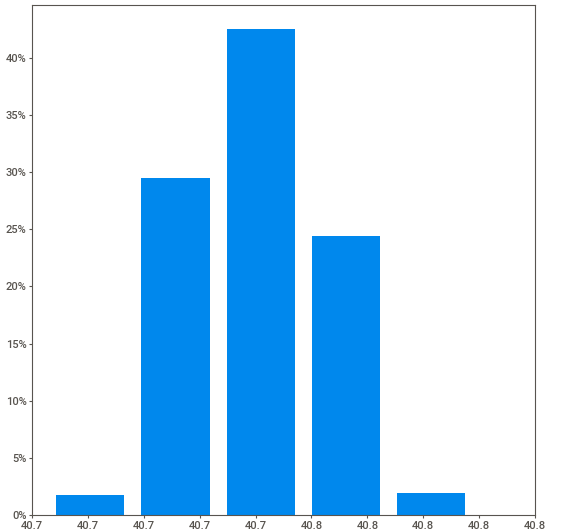
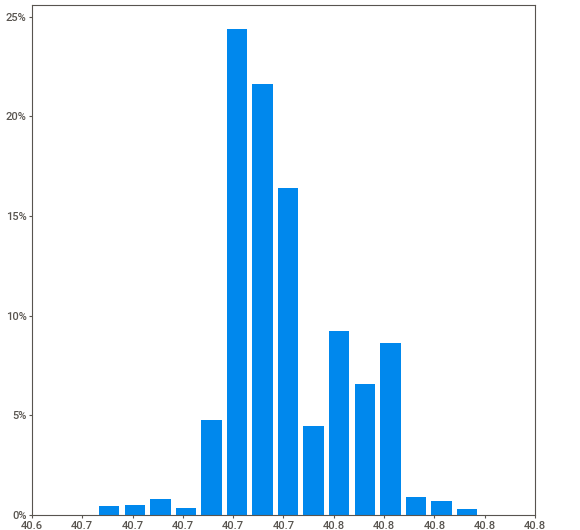
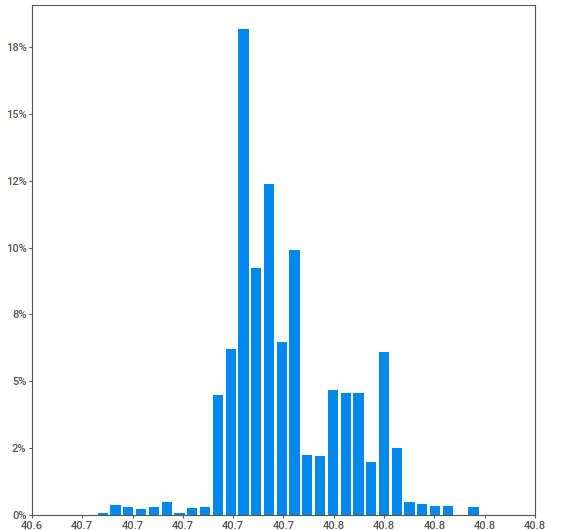
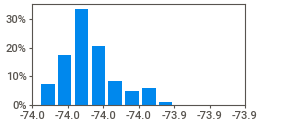
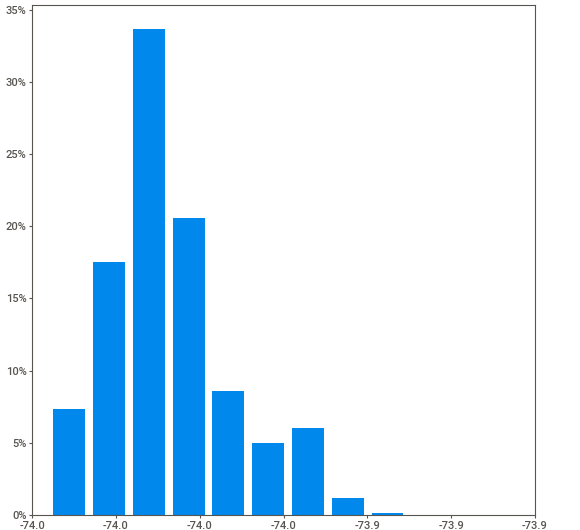
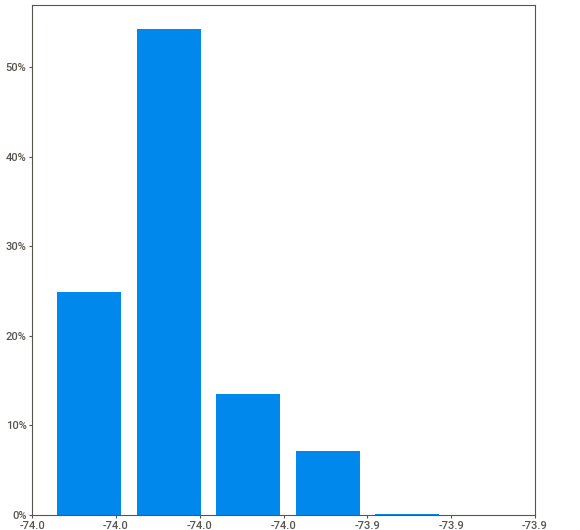
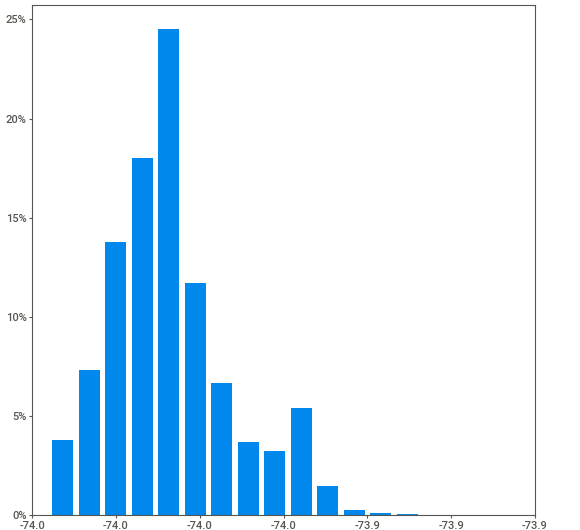
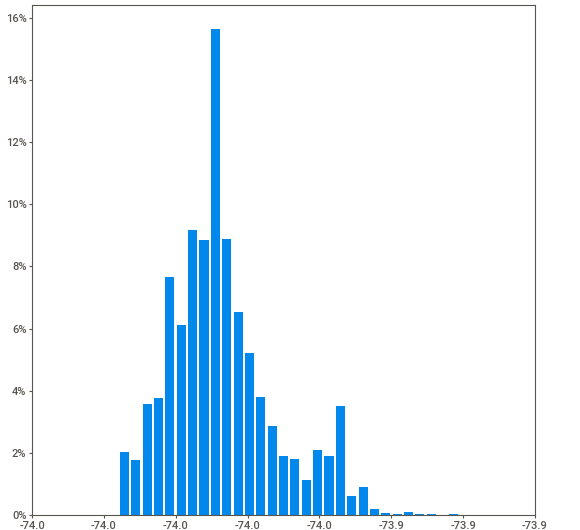
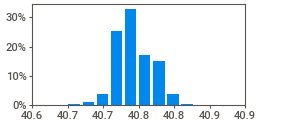
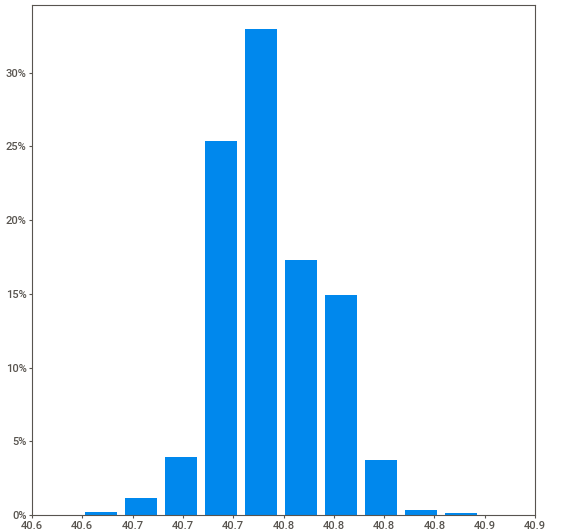
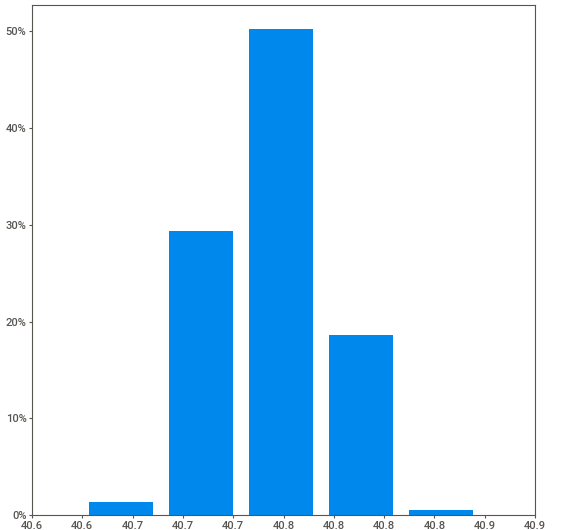
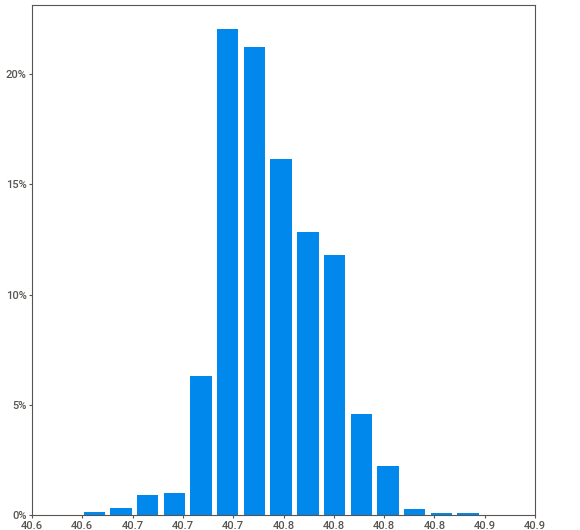
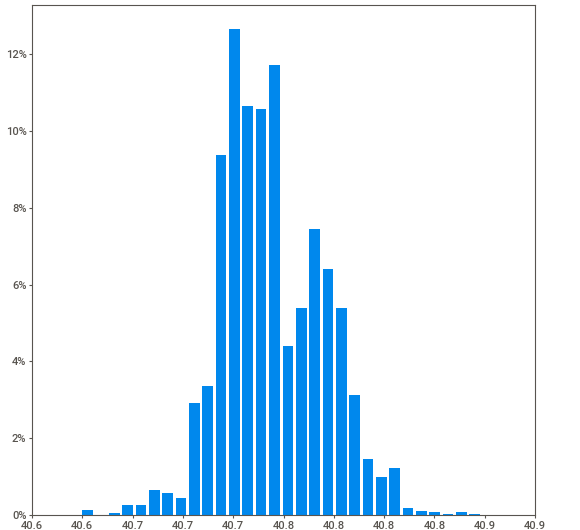
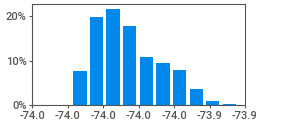
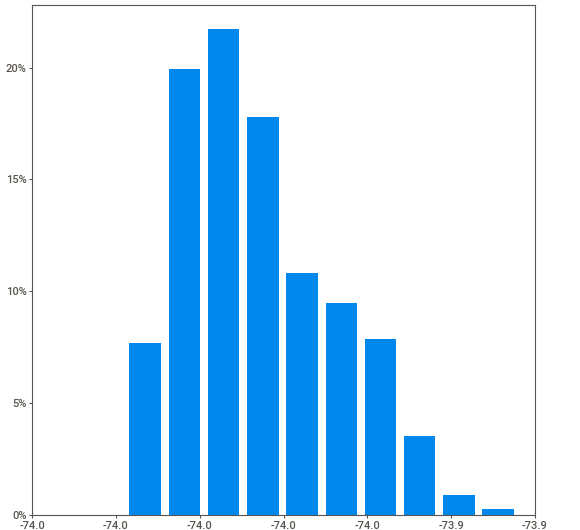
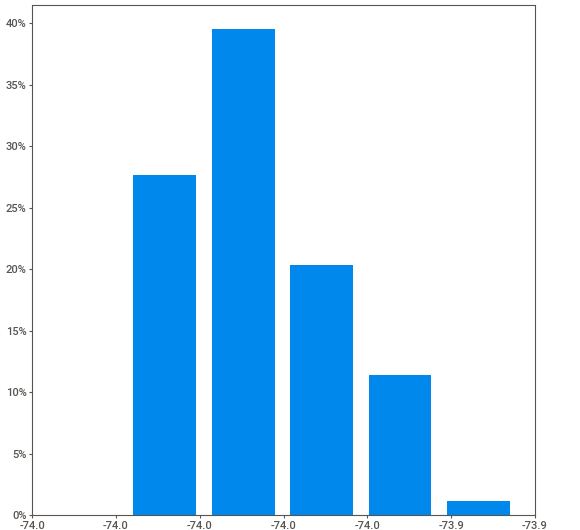
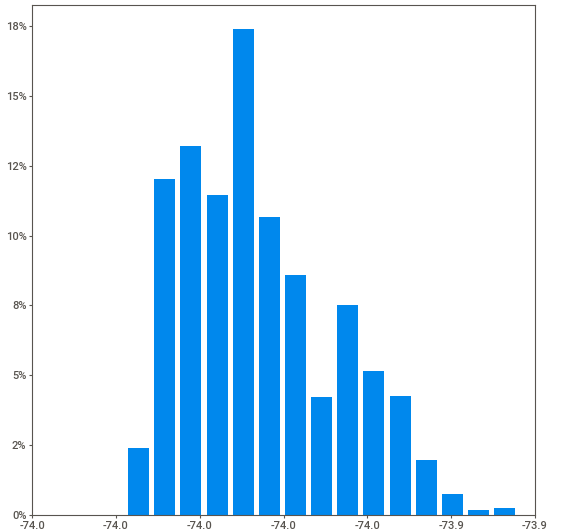
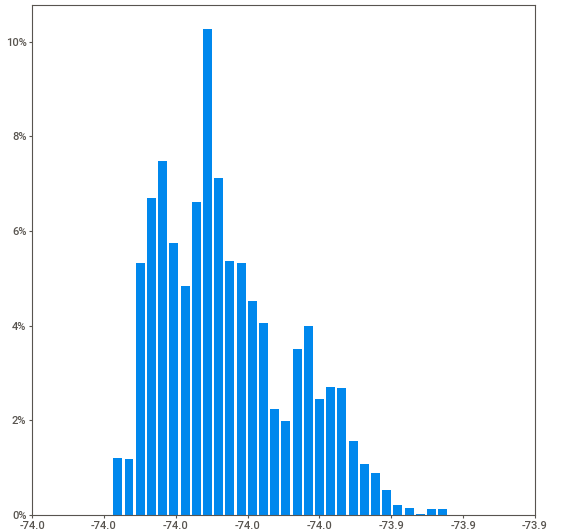
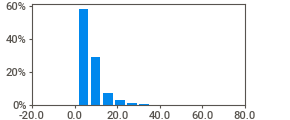
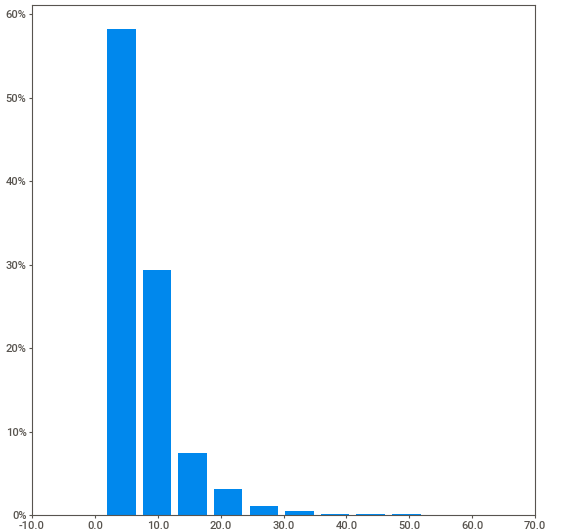
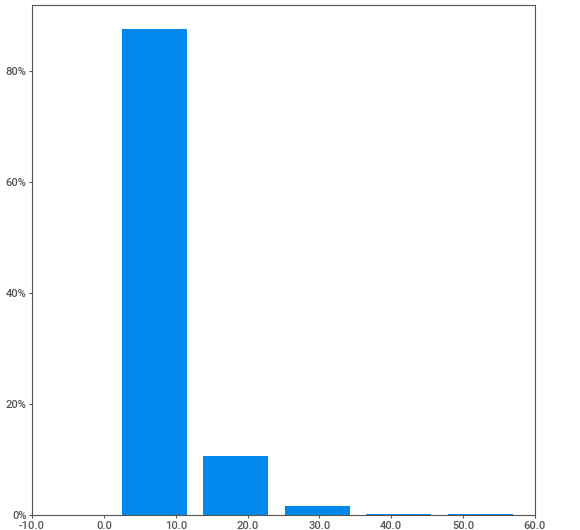
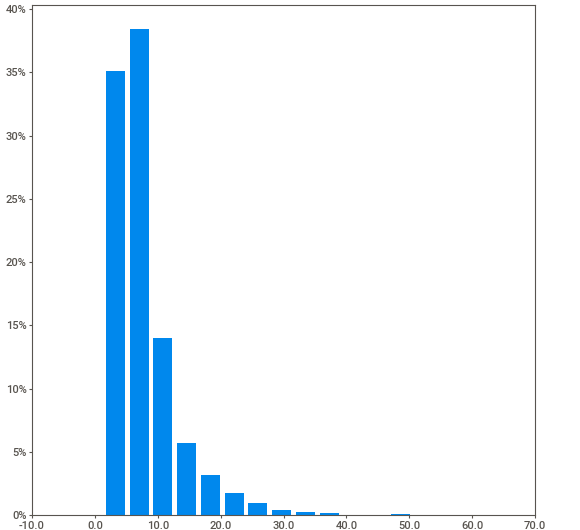
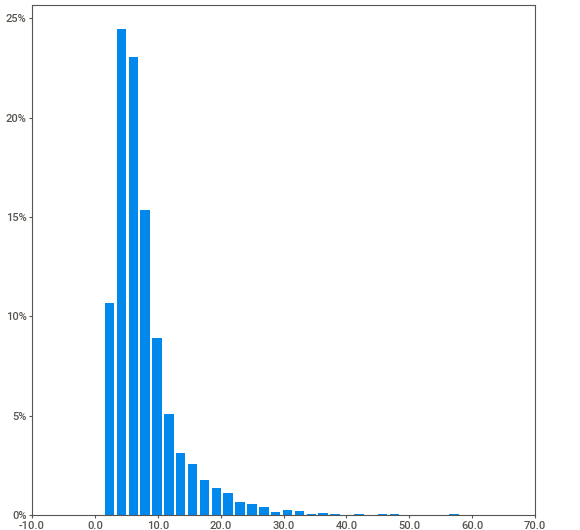
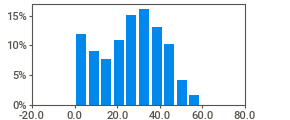
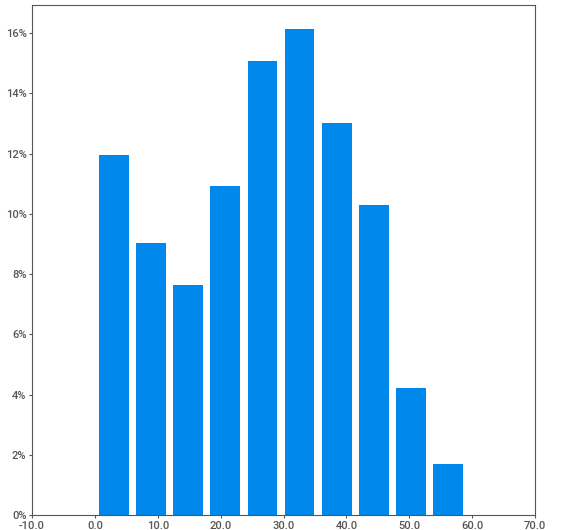
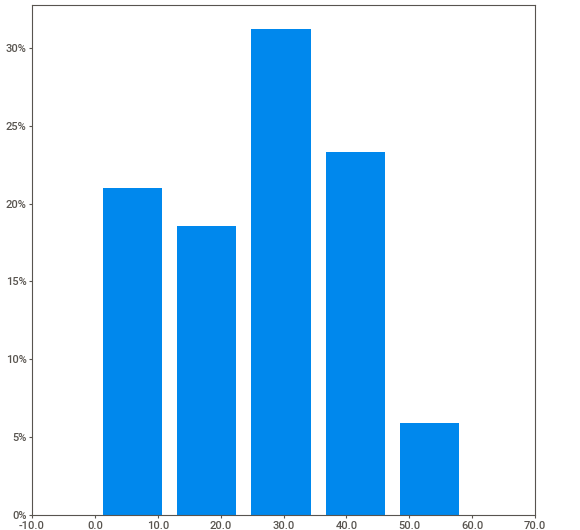
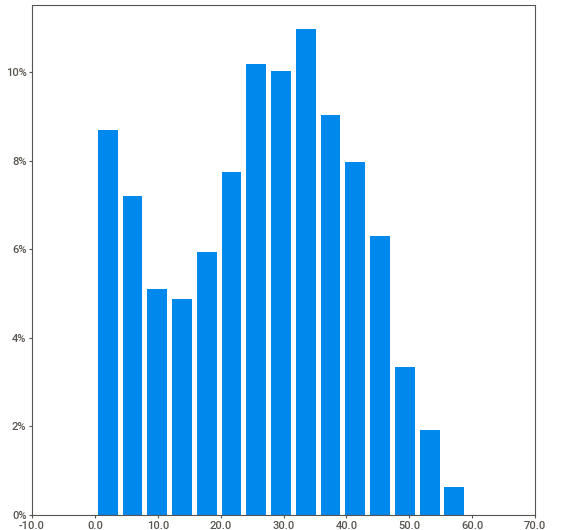
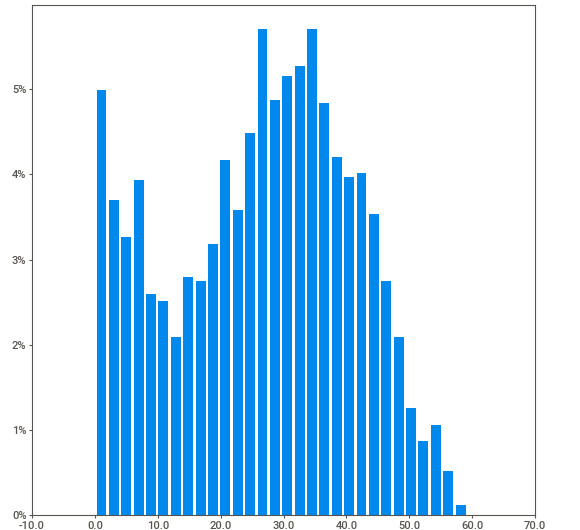
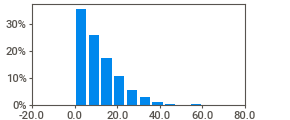
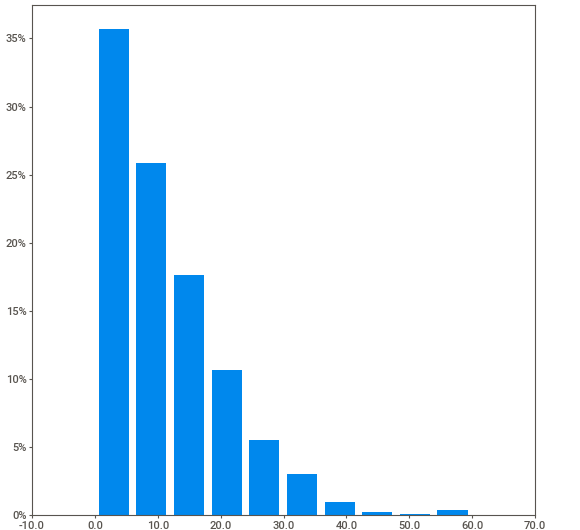
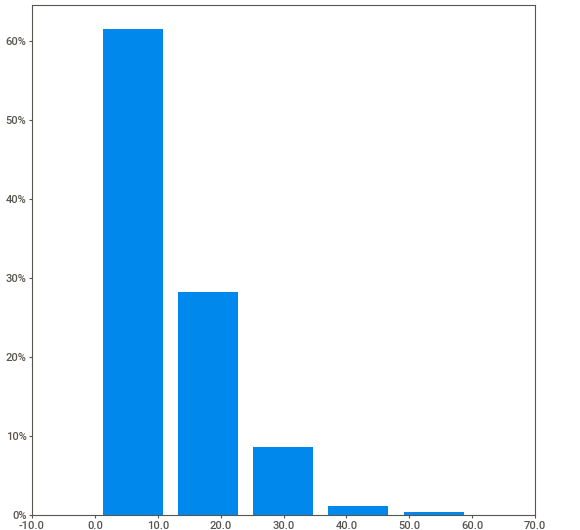
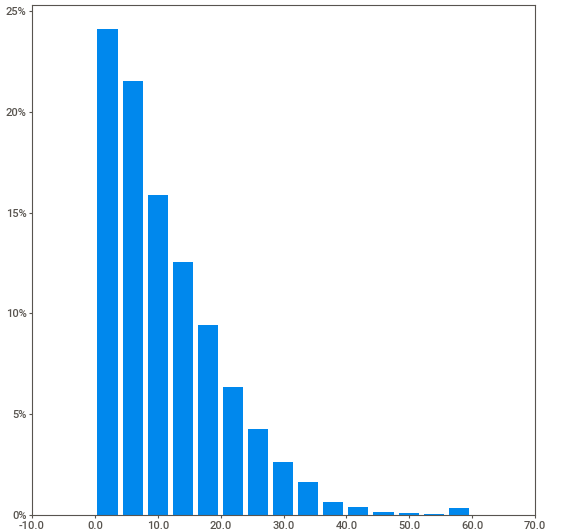
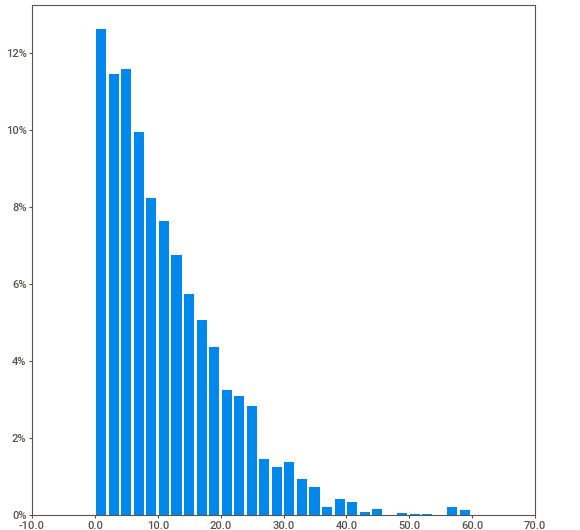
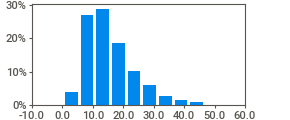
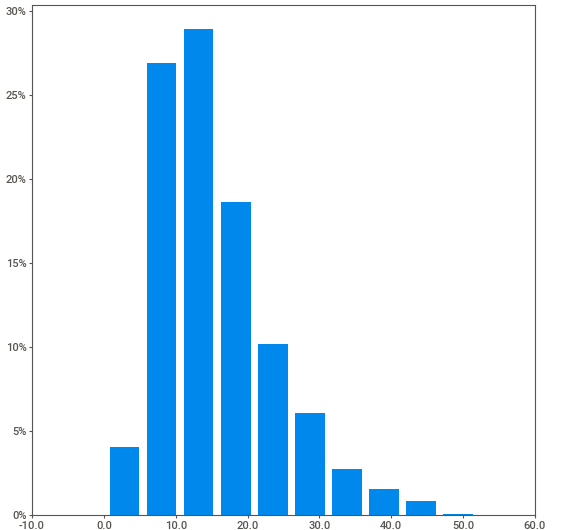
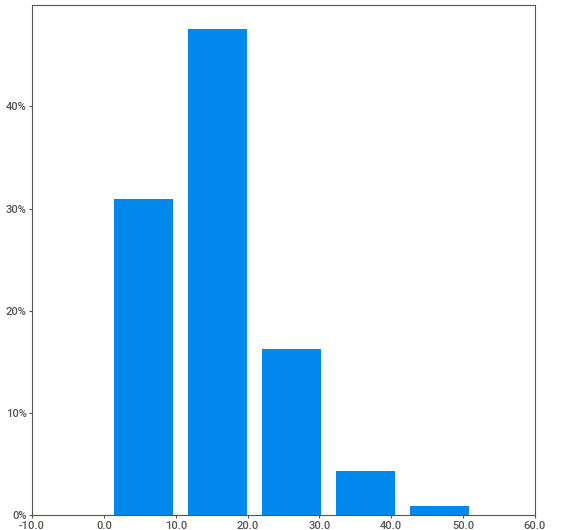
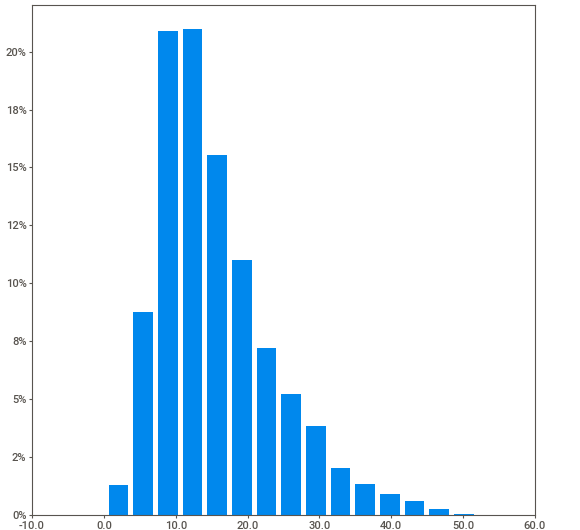
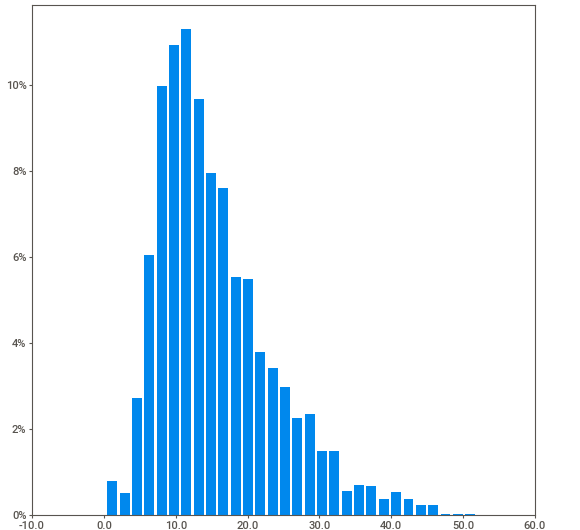
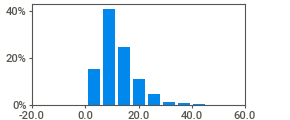
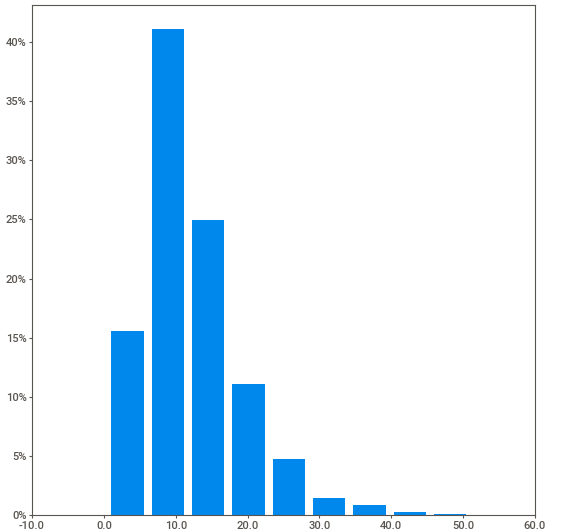
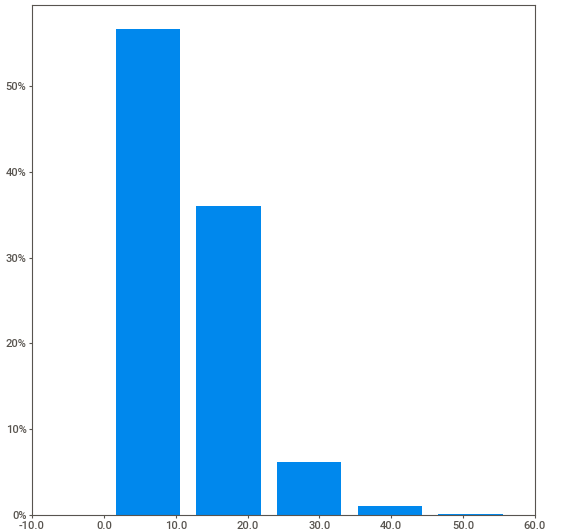
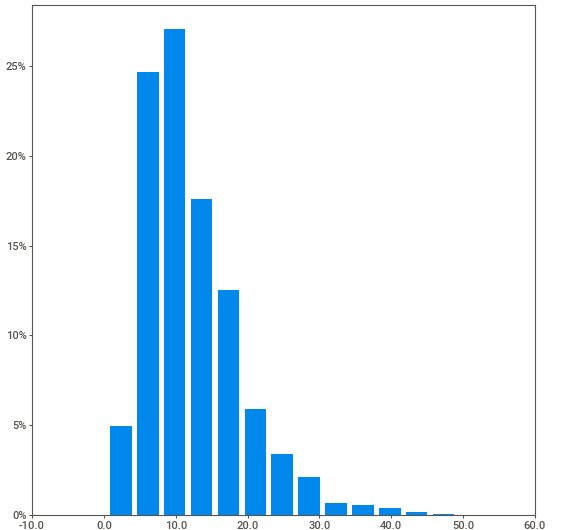
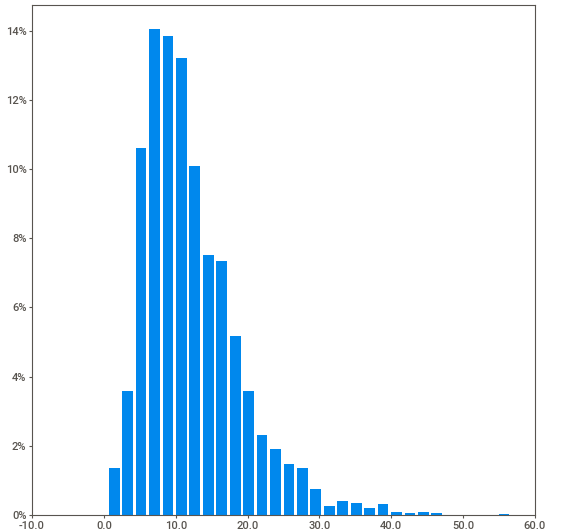
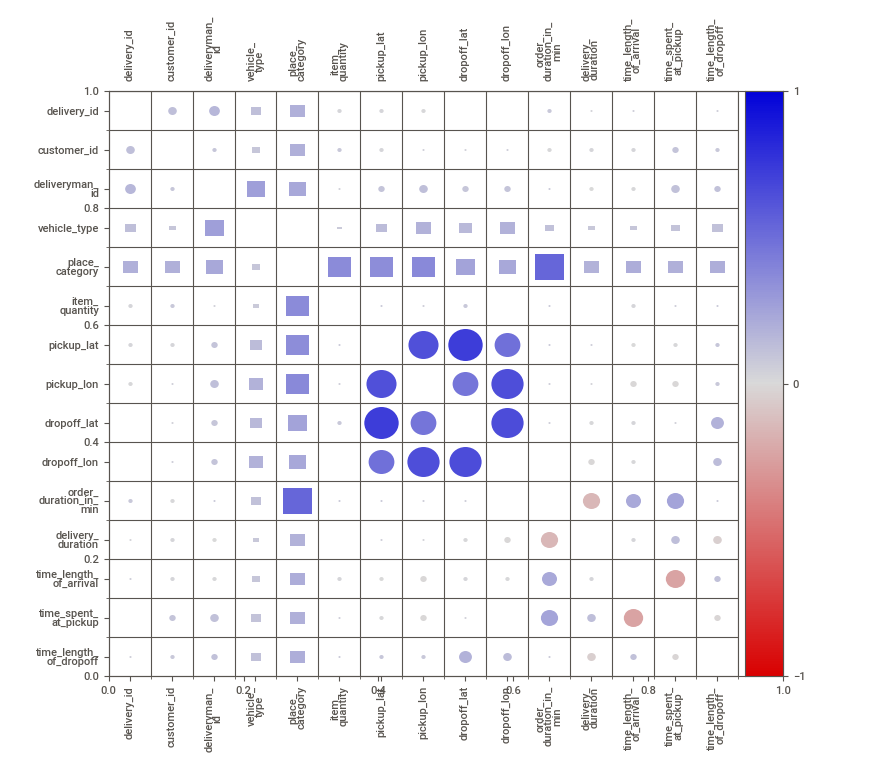
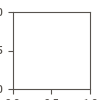

In [14]:
report.show_notebook(layout='vertical')

## Load to Google Sheets

In [15]:
# Open gsheet 
sh = gc.open('data')

# Define which sheet to open in the file
wks = sh[0]

In [16]:
# pass dataframe to gsheet
row = 1
col = 1
wks.set_dataframe(df, (row, col), copy_index=False, copy_head=True, extend=True, fit=False, escape_formulae=True, nan='')